In [1]:
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter 
import matplotlib.gridspec as gridspec
import os 
import glob
import re
os.chdir('/resstore')

/tmp/ipykernel_128588/1429019085.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


In [2]:
# read example file to locate varibale name 
h1_file_path = 'b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h1.2100-01-01-00000.nc'
ds_h1 = xr.open_mfdataset(h1_file_path)
ds_h1

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, mlat: 97, mlon: 80, lev: 126, ilev: 127,
                   time: 30, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * mlat          (mlat) float64 -90.0 -88.12 -86.24 -84.33 ... 86.24 88.12 90.0
  * mlon          (mlon) float64 -180.0 -175.5 -171.0 ... 166.5 171.0 175.5
  * lev           (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 970.6 992.6
  * ilev          (ilev) float64 3.551e-10 4.559e-10 5.854e-10 ... 985.1 1e+03
  * time          (time) object 2100-01-01 00:00:00 ... 2100-01-30 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/113)
    gw            (lat) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(126,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(126,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(127,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(127,), meta=np.ndarray>
    ...            ...
    UI            (time, lev, lat, lon) float32 dask.array<chunksize=(30, 126, 96, 144), meta=np.ndarray>
    V             (time, lev, lat, lon) float32 dask.array<chunksize=(30, 126, 96, 144), meta=np.ndarray>
    VI            (time, lev, lat, lon) float32 dask.array<chunksize=(30, 126, 96, 144), meta=np.ndarray>
    WI            (time, lev, lat, lon) float32 dask.array<chunksize=(30, 126, 96, 144), meta=np.ndarray>
    Z3            (time, lev, lat, lon) float32 dask.array<chunksize=(30, 126, 96, 144), meta=np.ndarray>
    e             (time, lev, lat, lon) float32 dask.array<chunksize=(30, 126, 96, 144), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FX2100f19f19mg16NaFeMgiontransport
    logname:           earfw
    host:              d8s5b4.arc4.leed
    initial_file:      /resstore/b0154/Data/earfw/MCHEM24/Joe_WACCMX_2_WF_lev...
    topography_file:   /nobackup/earfw/cesm2_inputdata//atm/cam/topo/USGS-gto...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1

# Initial Climatology

In [5]:
# File pattern and regex
file_pattern = 'b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/*.nc'
regex = r'.*h2\.2100-(\d{2})-(\d{2})\.*'

# define chosen variable
var = 'T'

# Find and group files by month
file_paths = sorted(glob.glob(file_pattern))
# print("Files found:", file_paths)

files_by_month = {}
monthly_averages = {}
seasonal_averages = {season: [] for season in ["spring", "summer", "autumn", "winter"]}

for file_path in file_paths:
    match = re.search(regex, file_path)
    if match:
        month = int(match.group(1))  # Extract month
        day = int(match.group(2))    # Extract day (if needed later)
        files_by_month.setdefault(month, []).append(file_path)
    else:
        print(f"Skipping file with unexpected format: {file_path}")

# Compute monthly averages
for month, files in files_by_month.items():
    print(f"Processing month {month} with {len(files)} files.")
    ds = xr.open_mfdataset(files, combine='by_coords')
    if var in ds:
        monthly_averages[month] = ds[var].mean(dim='time')
    else:
        print("Variable " + str(var) + " not found in files for month {month}.")
    ds.close()

# Compute seasonal averages
season_months = {"spring": [3, 4, 5], "summer": [6, 7, 8], "autumn": [9, 10, 11], "winter": [12, 1, 2]}
for season, months in season_months.items():
    seasonal_data = []
    for month in months:
        if month in monthly_averages:
            seasonal_data.append(monthly_averages[month])
    if seasonal_data:
        seasonal_averages[season] = sum(seasonal_data) / len(seasonal_data)

# Print summary
print("Monthly Averages:", list(monthly_averages.keys()))
print("Seasonal Averages:", list(seasonal_averages.keys()))

Skipping file with unexpected format: b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h0.2100-01.nc
Skipping file with unexpected format: b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h0.2100-02.nc
Skipping file with unexpected format: b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h0.2100-03.nc
Skipping file with unexpected format: b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h0.2100-04.nc
Skipping file with unexpected format: b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h0.2100-05.nc
Skipping file with unexpected format: b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h0.2100-06.nc
Skipping file with unexpected format: b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16N

ValueError: All-NaN slice encountered

In [12]:
# Create a list to hold monthly DataArrays
monthly_data = []

for month in range(1, 13):  # Loop through months 1 to 12
    if month in monthly_averages:
        da = monthly_averages[month]
        # Add a 'month' dimension if it doesn't exist
        if 'month' not in da.dims:
            da = da.expand_dims(dim={'month': [month]})
        else:
            da = da.assign_coords(month=[month])  # Assign the correct month value
        monthly_data.append(da)
    else:
        # Handle missing months by appending a NaN-filled array
        if len(monthly_data) > 0:
            template = monthly_data[0]
            nan_da = xr.full_like(template, np.nan)
            if 'month' not in nan_da.dims:
                nan_da = nan_da.expand_dims(dim={'month': [month]})
            else:
                nan_da = nan_da.assign_coords(month=[month])
            monthly_data.append(nan_da)

# Combine all monthly DataArrays along the 'month' dimension
globals()[f'{var}_monthly_avg'] = xr.concat(monthly_data, dim='month')

# Check the resulting DataArray
print(globals()[f'{var}_monthly_avg'])


<xarray.DataArray 'T' (month: 12, lev: 126, lat: 96, lon: 144)>
dask.array<concatenate, shape=(12, 126, 96, 144), dtype=float32, chunksize=(1, 126, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lev      (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 929.6 970.6 992.6


Dimensions of T_month_2d: ('lat', 'lon')
Shape of T_month_2d: (96, 144)


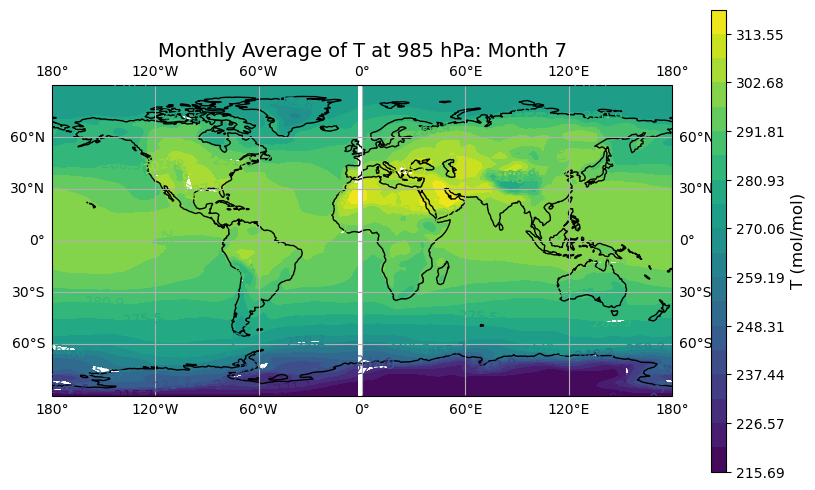

In [17]:
selected_month = 7 # Change this to plot other months
selected_alt = 985 # hPa 

if selected_month in globals()[f'{var}_monthly_avg']['month']:
    # Get the monthly average DataArray
    globals()[f'{var}_month'] = globals()[f'{var}_monthly_avg'].sel(month=selected_month)
    
    # Ensure var_month is 2D
    if 'lev' in globals()[f'{var}_month'].dims:
        globals()[f'{var}_month_2d'] = globals()[f'{var}_month'].sel(lev=selected_alt, method='nearest') # selects chosen alt 
    else:
        globals()[f'{var}_month_2d'] = globals()[f'{var}_month']  # Already 2D
    
    # Ensure no residual dimensions other than lat and lon
    globals()[f'{var}_month_2d'] = globals()[f'{var}_month_2d'].mean(dim=[dim for dim in globals()[f'{var}_month_2d'].dims if dim not in ['lat', 'lon']])
    
    # Extract latitude and longitude
    lat = globals()[f'{var}_month_2d']['lat'].values
    lon = globals()[f'{var}_month_2d']['lon'].values
    
    # Check dimensions
    print(f"Dimensions of {var}_month_2d:", globals()[f'{var}_month_2d'].dims)
    print(f"Shape of {var}_month_2d:", globals()[f'{var}_month_2d'].shape)
    
    # Create a figure with Cartopy
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Contour plot of variable 
    contour = ax.contourf(lon, 
                         lat, 
                         globals()[f'{var}_month_2d'], 
                         # colors='black', 
                         transform=ccrs.PlateCarree(), 
                         levels=np.linspace(globals()[f'{var}_month_2d'].min().values, globals()[f'{var}_month_2d'].max().values, 20))
    plt.clabel(contour, inline=True, fontsize=10)
   
    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30)
    cbar.set_label(f'{var} (mol/mol)', fontsize=12)
    
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    
    # Add title
    ax.set_title(f'Monthly Average of {var} at {selected_alt} hPa: Month {selected_month}', fontsize=14)

    # Show the plot
    plt.show()
else:
    print(f"No data available for month {selected_month}.")
